# Importazione librerie e dichiarazione dei percorsi delle cartelle

In [1]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import random
import joblib
import pickle

from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# Percorso dove si trovano le cartelle
main_path = "C:/Users/valer/OneDrive/Desktop/Magistrale/"

image_folder = main_path + "WiderPerson/Images/"
annotations_folder = main_path + "WiderPerson/Annotations"

# Percorsi dei file di suddivisione e delle immagini
train_split_file = main_path + "Data_Assignment_2/split_positive/train_assignment.txt"
val_split_file = main_path + "Data_Assignment_2/split_positive/val_assignment.txt"
test_split_file = main_path + "Data_Assignment_2/split_positive/test_assignment.txt"

# Definizione dei percorsi delle cartelle con le immagini negative
negative_train_folder = main_path + "Data_Assignment_2/negative/train_neg/train_neg"
negative_val_folder = main_path + "Data_Assignment_2/negative/val_neg/val_neg"
negative_test_folder = main_path + "Data_Assignment_2/negative/test_neg/neg"

# 1&2. Prepazione del Dataset

Varie definizioni di funzioni

In [3]:
# Definizione della dimensione della finestra
W, H = 64, 128

Definizione di funzioni per la creazione del dataset

In [4]:
# Definizione della dimensione della bounding box di base
W, H = 64, 128

# Definizione della funzione per leggere il file di annotazione
def read_annotations_from_file(annotation_file):
    annotations = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines[1:]:  # Ignoriamo la prima riga poichè è il numero di annotazioni
            annotation_info = line.strip().split()
            class_label = int(annotation_info[0])
            x1, y1, x2, y2 = map(int, annotation_info[1:])
            if class_label == 1:
                annotations.append({'class_label': class_label, 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})
    return annotations

# Definisco funzione per estrarre gli HOG_DESCRIPTOR
def extract_hog_descriptor(image):
    # Creazione di un oggetto HOGDescriptor
    hog = cv2.HOGDescriptor()   # i parametri di default hanno la winSize=(64,128)
    # Calcolo del descrittore HOG per l'immagine
    hog_descriptor = hog.compute(image)

    return hog_descriptor

# Definisco funzione per preparare i dati
def prepare_data(image_path, annotations, output_size=(W, H), image_name=None):
    
    image = cv2.imread(image_path)
    
    hog_positive_samples = []
    
    for annotation in annotations:
        class_label = annotation['class_label']
        if class_label == 1:  # Controlla se l'etichetta della classe è uguale a 1
            try:
                x1, y1, x2, y2 = annotation['x1'], annotation['y1'], annotation['x2'], annotation['y2']  # Aggiornamento delle chiavi
                # Effettuo il crop dell'immagine
                cropped_image = image[y1:y2, x1:x2]  # Aggiornamento dei valori di ritaglio
                
                # Resize dell'immagine
                resized_image = cv2.resize(cropped_image, output_size)

                # Estrazione degli Hog
                hog_descriptor = extract_hog_descriptor(resized_image)
                
                hog_positive_samples.append([class_label, hog_descriptor])
            except Exception as e:
                print(f"Errore durante la preparazione dei dati dell'immagine {image_path}: {e}")
    
    return hog_positive_samples

# Definisco funzione che genera i campioni negativi
def generate_negative_samples(image_path, num_samples, window_size=(W, H)):
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    window_size = [0,0]
    
    if width <= height:
        window_size[0] = width//2 - ((width//2) % 2)
        window_size[1] = window_size[0] * 2
    else:
        window_size[1] = height//2 - ((height//2) % 2)
        window_size[0] = window_size[1] / 2

    hog_negative_samples = []
    
    for _ in range(num_samples):

        scala_casuale = np.random.randint(1, 4)

        window_scaled = [int(window_size[0] // scala_casuale), int(window_size[1] // scala_casuale)]

        x = np.random.randint(0, width - window_scaled[0])
        y = np.random.randint(0, height - window_scaled[1])

        # Crop della finestra
        window = image[y:y+ window_scaled[1], x:x+ window_scaled[0]]

        # Resize dell'immagine
        resized_image = cv2.resize(window, (64,128))

        # Estrazione hog
        hog_descriptor = extract_hog_descriptor(resized_image)
        
        hog_negative_samples.append([0, hog_descriptor])
    
    return hog_negative_samples

def generate_negative_samples_from_folder(folder_path, output_size=(W, H)):
    hog_negative_samples = []
    filenames = os.listdir(folder_path)
    for filename in tqdm(filenames, desc='Generate Negative Samples'):
        image_path = os.path.join(folder_path, filename)
        num_samples = 100
        negative_samples = generate_negative_samples(image_path, num_samples, output_size)
        hog_negative_samples.extend(negative_samples)
    return hog_negative_samples


# ---------------------------------------------- SPLIT DATASET ------------------------------------------
# Leggere i file di suddivisione
def read_split_file(split_file):
    with open(split_file, 'r') as file:
        image_names = file.read().splitlines()
    return image_names

# Funzione per distribuire le immagini nei set di dati
def split_images(image_names, image_folder,annotations_folder):
    data = []
    annotations_list = []

    for image_name in tqdm(image_names, desc="Generate Positive Samples"):
        image_path = os.path.join(image_folder, image_name + '.jpg')
        annotations_path = os.path.join(annotations_folder, image_name + '.jpg.txt')
        annotations = read_annotations_from_file(annotations_path)
        annotations_list.extend(annotations)
        # Procediamo nel preparare i dati andando a calcolare gli HOG Descriptor
        data.extend(prepare_data(image_path, annotations))
    return data, annotations_list


Genero i campioni Positivi

In [5]:
# Ottenere i nomi delle immagini nei set di dati contenuti nella cartella split_positive
train_names_positive = read_split_file(train_split_file)
val_names_positive = read_split_file(val_split_file)
test_names_positive = read_split_file(test_split_file)

In [5]:
# Genero i dataset dei positiviimage_folder
train_positive_data, annotations = split_images(train_names_positive, image_folder, annotations_folder )
val_positive_data, _ = split_images(val_names_positive, image_folder, annotations_folder)

Generate Positive Samples:  58%|█████▊    | 4027/7000 [00:32<00:21, 135.92it/s]

Errore durante la preparazione dei dati dell'immagine C:/Users/valer/OneDrive/Desktop/Magistrale/WiderPerson/Images/011765.jpg: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Errore durante la preparazione dei dati dell'immagine C:/Users/valer/OneDrive/Desktop/Magistrale/WiderPerson/Images/011765.jpg: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Errore durante la preparazione dei dati dell'immagine C:/Users/valer/OneDrive/Desktop/Magistrale/WiderPerson/Images/011765.jpg: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



Generate Positive Samples: 100%|██████████| 1000/1000 [00:07<00:00, 129.96it/s]


Genero i campioni negativi

In [6]:
# Generazione degli HOG descriptor per i campioni negativi nei set di dati di addestramento, validazione e test
train_negative_samples = generate_negative_samples_from_folder(negative_train_folder)
val_negative_samples = generate_negative_samples_from_folder(negative_val_folder)
test_negative_samples = generate_negative_samples_from_folder(negative_test_folder)

Generate Negative Samples: 100%|██████████| 203/203 [00:04<00:00, 45.56it/s]


In [7]:
def create_dataset(positive_data, negative_samples, percentuale=1):
    positive_sample_size = int(percentuale * len(positive_data))
    negative_sample_size = int(percentuale * len(negative_samples))
    return random.sample(positive_data, positive_sample_size) + random.sample(negative_samples, negative_sample_size)

In [8]:
# Unione dei campioni positivi e negativi nei set di dati di addestramento, validazione e test
train_dataset = create_dataset(train_positive_data, train_negative_samples)
val_dataset = create_dataset(val_positive_data, val_negative_samples)

In [9]:
random.shuffle(train_dataset)
random.shuffle(val_dataset)

In [10]:
# Salvataggio del dataset di addestramento
with open('train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)

# Salvataggio del dataset di validazione
with open('val_dataset.pkl', 'wb') as f:
    pickle.dump(val_dataset, f)


In [7]:
# Caricamento del dataset di addestramento
with open('train_dataset.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

# Caricamento del dataset di validazione
with open('val_dataset.pkl', 'rb') as f:
    val_dataset = pickle.load(f)


In [8]:
X_train = [item[1] for item in train_dataset]
y_train = [item[0] for item in train_dataset]

X_val = [item[1] for item in val_dataset]
y_val = [item[0] for item in val_dataset]

# 3. Pre-processing

Come pre-processing degli hogDescriptor è stato scelto di usare la PCA in modo da mantenere soltano le features principali 

In [12]:
pca = PCA(0.95, svd_solver='full')
pca.fit(X_train)

# Salvataggio della PCA su disco
joblib.dump(pca, 'pca_model.pkl')

['pca_model.pkl']

In [6]:
# Caricamento della PCA da disco
pca = joblib.load('pca_model.pkl')

In [13]:
hog_train = pca.transform(X_train)
hog_val = pca.transform(X_val)

# Inseriamo i vettori riga di new_hog in una lista in modo da comporre il dataset di train e validation
X_train = [i for i in hog_train]
X_val = [i for i in hog_val]

Visualizziamo il numero di features rilevanti

In [14]:
len(hog_train[0])

1382

# 4. Definizione del modello SVC

In [15]:
# Applico la GridSearch
parameters = [0.01, 0.1, 1, 10, 100]

best_f1 = 0
report_c = []
best_model = None
for c in parameters:

    # Addestramento del modello
    classifier = LinearSVC(C=c)
    classifier.fit(X_train, y_train)

    # Valutazione del modello
    y_pred_val = classifier.predict(X_val)
    f1_val= f1_score(y_val,y_pred_val)

    if f1_val > best_f1:
        best_f1 = f1_val
        best_model = classifier

    report_c.append((c, f1_val))

print(report_c)

# Salvataggio del classificatore su disco
joblib.dump(best_model, main_path + 'LinearSVC_model_with_PCA.pkl')

c:\Users\valer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\valer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\valer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[(0.01, 0.9046661985132092), (0.1, 0.9042542882062217), (1, 0.9042808343629625), (10, 0.9023765996343692), (100, 0.8644059230808107)]


['C:/Users/valer/OneDrive/Desktop/Magistrale/LinearSVC_model_with_PCA.pkl']

In [23]:
# Caricamento del classificatore da disco senza PCA 
classifier = joblib.load(main_path + 'linear_svc_classifierBest_modelCon100noPCA.pkl')

# 5. Sliding Window MultiScale

## 5.1. Ricerca delle dimensioni medie delle immagini

In [8]:
def find_dim_img(image_folder, train_names_positive, negative_train_folder):
    dimensions_counter = Counter()
    list_name_img = train_names_positive 
    filenames = os.listdir(negative_train_folder)

    for image_name_positive in list_name_img:
        imagepath = os.path.join(image_folder, image_name_positive)
        image = cv2.imread(imagepath + '.jpg')
        h, w, _ = image.shape
        dimensions_counter[(w, h)] += 1

    for image_name_negative in filenames:
        image_path = os.path.join(negative_train_folder, image_name_negative)
        image = cv2.imread(image_path)
        h, w, _ = image.shape
        dimensions_counter[(w, h)] += 1

    return dimensions_counter

In [9]:
def plot_dimensions_counter(dimensions_counter):
    dimensioni = dimensions_counter.keys()
    frequenze = dimensions_counter.values()

    # Estrai larghezza e altezza separatamente
    widths = [dim[0] for dim in dimensioni]
    heights = [dim[1] for dim in dimensioni]

    frequenze = [f for f in frequenze]

    print('W: ', widths)

    # Crea il plot
    plt.figure(figsize=(4, 3))
    plt.scatter(widths, heights, s=frequenze, alpha=0.5)
    plt.xlabel('Larghezza')
    plt.ylabel('Altezza')
    plt.xlim(0,1000)
    plt.ylim(0,1000)
    plt.title('Distribuzione delle Dimensioni delle Immagini')
    plt.grid(True)
    plt.show()

W:  [550, 551, 450, 600, 600, 3008, 800, 600, 460, 900, 550, 800, 690, 550, 3456, 640, 680, 400, 501, 2672, 800, 634, 600, 500, 490, 451, 500, 640, 860, 624, 600, 539, 1000, 300, 950, 800, 600, 690, 410, 550, 440, 592, 709, 480, 940, 4896, 1200, 800, 750, 530, 550, 900, 500, 580, 550, 300, 3504, 268, 690, 1024, 750, 666, 512, 940, 560, 490, 600, 819, 670, 500, 640, 2048, 720, 580, 540, 400, 1600, 690, 690, 500, 406, 1024, 533, 670, 800, 600, 853, 600, 1520, 550, 690, 490, 650, 690, 410, 670, 530, 1200, 800, 480, 583, 1000, 629, 650, 776, 400, 900, 750, 557, 500, 406, 1024, 550, 600, 550, 936, 690, 540, 900, 1024, 550, 300, 940, 1155, 500, 550, 640, 266, 720, 450, 700, 449, 690, 749, 640, 529, 500, 550, 450, 550, 700, 654, 551, 750, 573, 592, 600, 750, 1000, 960, 580, 800, 1200, 500, 640, 1280, 800, 550, 640, 600, 800, 450, 950, 800, 550, 500, 500, 480, 580, 570, 900, 580, 500, 821, 545, 500, 500, 446, 450, 450, 680, 550, 500, 431, 729, 800, 1200, 639, 819, 450, 690, 591, 213, 600, 4752

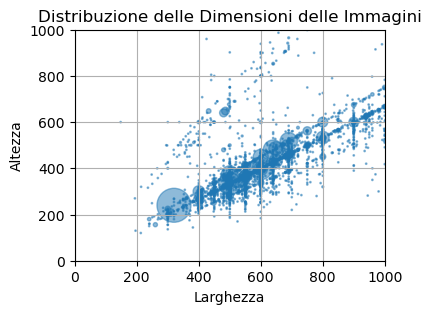

In [44]:
dimensions_counter = find_dim_img(image_folder, train_names_positive, negative_train_folder)
plot_dimensions_counter(dimensions_counter)

Secondo la distribuzione delle larghezze e altezze delle immagini di training (considerate immagini positive e negativa), 
e considerando i valori più frequenti di w,h evinciamo che la dimensione più frequente e cioè quella che abbiamo utilizzato per fare la resize in fase di test, è la dimensione 400,600

In [10]:
base_size= {'H':400, 'W':600}

## 5.2 Ricerca delle 3 scale più frequenti
Le scale saranno applicate nello sliding window multi-scale

### 5.2.1 Riscalatura altezze bounding box

In [46]:
#Funzione per normalizzare le altezze 
def normalized_h(image_folder, annotations_folder,train_names_positive):
    list_name_img = train_names_positive 
    h_base = base_size['H']
    h_normalized_list = []

    for image_name_positive in list_name_img:
        imagepath = os.path.join(image_folder, image_name_positive)
        image = cv2.imread(imagepath + '.jpg')
        h, _, _ = image.shape
        annotation_file_path = annotations_folder + '/' + image_name_positive + '.jpg'
        annotation_file_path = os.path.join(annotation_file_path +'.txt')
        annotations = read_annotations_from_file(annotation_file_path)
        for annotation in annotations:
            y2 = annotation['y2']
            y1 = annotation['y1']
            h_bb = y2-y1
            h_normalized= int(np.round((h_base*h_bb)/h))
            h_normalized_list.append(h_normalized)

    return h_normalized_list 

# Definisco la funzione che mi permetterà di effettuare il plot
def plot_h(list):
    plt.figure(figsize=(4, 3))
    plt.hist(list, bins=100, color='skyblue', edgecolor='black')
    plt.title('Distribuzione delle altezze ')
    plt.xlabel('Altezza')
    plt.ylabel('Frequenza')
    plt.xlim(0,300)
    plt.grid(True)
    plt.show()

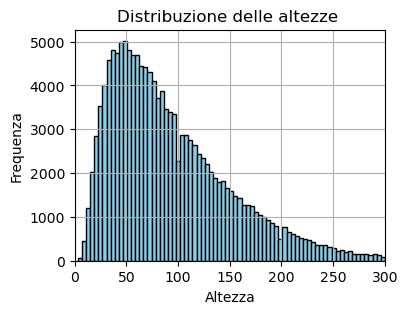

In [47]:
h_normalized_list = normalized_h(image_folder, annotations_folder,train_names_positive)
plot_h(h_normalized_list)

Secondo l'analisi riportata nel plot scegliamo come altezze su cui calcolare le scale le seguenti: 50, 100, 150

In [11]:
h_most_frequent = [50, 100, 150]

### 5.2.2 Calcolo delle 3 scale

In [12]:
#Funzione per trovare le scale in relazione a finestra bounding-box di dimensioni W=64, H=128
#Il rapporto deve essere : altezza-bb-frequente : altezza-bb-fissa-detection = H-image : H_resized 
def find_scale(h_most_frequent):
    scales=[]
    h_bb=128.00 #altezza bb-fissa 
    fattore_di_scala = 1
    for h in h_most_frequent: 
        #comune : h_bb = H : H_resized 
        fattore_di_scala = h_bb/h  #x img ridimensioanta/H immagine data 
        scales.append(fattore_di_scala)
    return scales

In [13]:
scales = find_scale(h_most_frequent)
scales = sorted(scales,reverse=True)
print("Le tre scale scelte sono:", scales)

Le tre scale scelte sono: [2.56, 1.28, 0.8533333333333334]


## 5.3 Multiscale sliding window procedure

In [14]:
def detect_pedestrians(image, classifier, scales=scales, stride=64, window_size=(64, 128), sigma=0.5, preprocessing=False):
    detections = []
    # Resized immagine 

    h,w,_ = image.shape
    resized_image_base = cv2.resize(image,(base_size['W'], base_size['H']))
    fx = base_size['W'] / w
    fy = base_size['H'] / h
    # Iterazione attraverso le diverse scale
    for scale in scales:
        image_gaussian = cv2.GaussianBlur(resized_image_base,(0,0),sigmaX=sigma,sigmaY=sigma)
        resized_image = cv2.resize(image_gaussian,None, fx=scale, fy=scale)
        #Iterazione attraverso le finestre scorrevoli con passo stride 
        for y in range(0, resized_image.shape[0] - window_size[1] + 1, stride):
            for x in range(0, resized_image.shape[1] - window_size[0] + 1, stride):                
                # Estrai la finestra corrente cui applicare le HOG 
                window = resized_image[y:y+window_size[1], x:x+window_size[0]]
                hog_features = extract_hog_descriptor(window) # sia il modello che la pca vogliono in input una lista di descrittori; poichè qui c'è un solo descrittore abbiamo bisogno di racchiuderlo tra quadre
                hog_features = [hog_features]
                if preprocessing:
                    hog_features = pca.transform(hog_features)

                predictions = classifier.predict(hog_features)
                scores = classifier.decision_function(hog_features)
                
                # Se la detection ==1 allora ho individuato un pedone
                if predictions == 1 :
                    # Calcolo delle coordinate della detection nella dimensione originale dell'immagine
                    x_original = int((x / scale)/fx)
                    y_original = int((y / scale)/fy)


                    #Calcola le dimensioni della finestra corrente rispetto all'immagine originale
                    window_width_original = int((window_size[0] / scale)/fx)
                    window_height_original = int((window_size[1] / scale)/fy)
                    x1 = x_original
                    y1 = y_original
                    x2 = int(x1 + window_width_original)
                    y2 = int(y1 + window_height_original)
                    

                    detection = {'class_label': 1, 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2 ,'score': scores, 'scale': scale}
                    detections.append(detection)
    
    return detections


# 6. Non-maxima suppression

In [16]:
def IoU(annotation_1, annotation_2):

    x1 = max(annotation_1['x1'], annotation_2['x1'])
    y1 = max(annotation_1['y1'], annotation_2['y1'])
    x2 = min(annotation_1['x2'], annotation_2['x2'])
    y2 = min(annotation_1['y2'], annotation_2['y2'])

    # Notiamo che in questo modo verifichiamo se le finestre si sovrappongono.
    # Poichè se le differenze tra le coordinate x o y risultano negative ciò vuol 
    # dire che le finestra non si sovrappongono quindi l'area sarà pari a 0
    # di conseguenza il valore di ritorno sarà 0
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    annotation_1_area = (annotation_1['x2'] - annotation_1['x1'] + 1) * (annotation_1['y2'] - annotation_1['y1'] + 1)
    annotation_2_area = (annotation_2['x2'] - annotation_2['x1'] + 1) * (annotation_2['y2'] - annotation_2['y1'] + 1)

    iou = intersection_area / float(annotation_1_area + annotation_2_area - intersection_area)

    return iou

def non_maxima_suppression(T, detections):

    Bnms = []
    for bi in detections:
        discard = False
        for bj in detections:
            if IoU(bi, bj) > T and bj['score'] > bi['score']:
                discard = True
        if not discard:
            Bnms.append(bi)
    
    return Bnms

# Definizione delle funzioni per la valutazione del modello

## Definizione funzioni per il calcolo delle metriche di valutazione

In [18]:
#Funzioni per calcolare FP,FP,TP con precision e recall
def counter_tp_fp_fn(detections, annotations):

    tp, fp, fn = 0, 0, 0
    
    # Conto i True Positive
    # Se trovo un true positive allora rimuovo
    for annotation in annotations:

        list_detections = []
        for detection in detections:
            if IoU(annotation, detection) > 0.5:
                list_detections.append((IoU(annotation, detection), detection))
        
        # Verifico se l'annotation ha almeno un intersezione maggiore di 0.5
        if len(list_detections) > 0:
            tp += 1
            # Ordino secondo la IoU di tutte le intersezioni tra l'annotation e le detections
            # e prendo quella con IoU maggiore e successivamente la rimuovo dalla lista delle detections
            lista_ordinata = sorted(list_detections, key=lambda x: x[0], reverse=True)
            detections.remove(lista_ordinata[0][1])
            # Rimuovo l'annotazione si interseca almeno una volta dal conteggio dei fn
            fn -= 1

    fp += len(detections)
    fn += len(annotations)   # ATTENZIONE: fn non sempre è uguale a len(annotation) poichè nella riga 44 sottraggo di 1 nel caso in cui ci sono delle intersezioni > 0.5

    return tp, fp, fn

def my_f1_score(tot_tp, tot_fp, tot_fn):
    if tot_tp == 0:
        return 0  # Gestione di una divisione per zero
    precision = tot_tp / (tot_tp + tot_fp)
    recall = tot_tp / (tot_tp + tot_fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1, precision, recall

## Test

In [27]:

def testing(classifier, image_test_names, image_folder, annotations_folder, T, preprocessing=False):

    tot_tp, tot_fp, tot_fn = 0, 0, 0
    
    for image_name in tqdm(image_test_names, desc="Testing"):
        image_path = os.path.join(image_folder, image_name + '.jpg')
        annotations_path = os.path.join(annotations_folder, image_name + '.jpg.txt')
        annotations = read_annotations_from_file(annotations_path)

        test_image = cv2.imread(image_path)

        detections = detect_pedestrians(test_image, classifier, scales=scales, stride=64, window_size=(64, 128),sigma=0.5, preprocessing=preprocessing)
        best_detections = non_maxima_suppression(T, detections)

        tp, fp, fn = counter_tp_fp_fn(best_detections, annotations)

        tot_tp += tp
        tot_fp += fp
        tot_fn += fn

    f1_score, precision, recall = my_f1_score(tot_tp, tot_fp, tot_fn)

    return f1_score, precision, recall, tot_tp, tot_fp, tot_fn

# Rilevamento miglior Threshold

In [33]:
T = [0.2, 0.4, 0.5, 0.6, 0.7]

report_T = []

for t in T:
    f1_score, precision, recall, tot_tp, tot_fp, tot_fn = testing(classifier, 
                                                                    val_names_positive, 
                                                                    image_folder, 
                                                                    annotations_folder, 
                                                                    t,
                                                                    preprocessing=False)
    
    print({'T':t, 'f1_score':f1_score, 'precision':precision, 
                    'recall': recall, 'tot_tp':tot_tp, 'tot_fp':tot_fp, 'tot_fn':tot_fn})

    report_T.append({'T':t, 'f1_score':f1_score, 'precision':precision, 
                    'recall': recall, 'tot_tp':tot_tp, 'tot_fp':tot_fp, 'tot_fn':tot_fn})

Testing: 100%|██████████| 1000/1000 [02:21<00:00,  7.07it/s]


{'T': 0.2, 'f1_score': 0.07455100976227737, 'precision': 0.05328986618938038, 'recall': 0.12403908148588999, 'tot_tp': 2501, 'tot_fp': 44431, 'tot_fn': 17662}


Testing: 100%|██████████| 1000/1000 [02:17<00:00,  7.27it/s]


{'T': 0.4, 'f1_score': 0.07646603410093444, 'precision': 0.046711908401984185, 'recall': 0.21063333829291275, 'tot_tp': 4247, 'tot_fp': 86672, 'tot_fn': 15916}


Testing: 100%|██████████| 1000/1000 [02:17<00:00,  7.29it/s]


{'T': 0.5, 'f1_score': 0.08227559833283203, 'precision': 0.04975988025196981, 'recall': 0.23741506720230124, 'tot_tp': 4787, 'tot_fp': 91415, 'tot_fn': 15376}


Testing: 100%|██████████| 1000/1000 [02:17<00:00,  7.26it/s]


{'T': 0.6, 'f1_score': 0.08227559833283203, 'precision': 0.04975988025196981, 'recall': 0.23741506720230124, 'tot_tp': 4787, 'tot_fp': 91415, 'tot_fn': 15376}


Testing: 100%|██████████| 1000/1000 [02:18<00:00,  7.24it/s]

{'T': 0.7, 'f1_score': 0.08227559833283203, 'precision': 0.04975988025196981, 'recall': 0.23741506720230124, 'tot_tp': 4787, 'tot_fp': 91415, 'tot_fn': 15376}


In [35]:
sorted(report_T, key=lambda x:x['f1_score'], reverse=True)

[{'T': 0.5,
  'f1_score': 0.08227559833283203,
  'precision': 0.04975988025196981,
  'recall': 0.23741506720230124,
  'tot_tp': 4787,
  'tot_fp': 91415,
  'tot_fn': 15376},
 {'T': 0.6,
  'f1_score': 0.08227559833283203,
  'precision': 0.04975988025196981,
  'recall': 0.23741506720230124,
  'tot_tp': 4787,
  'tot_fp': 91415,
  'tot_fn': 15376},
 {'T': 0.7,
  'f1_score': 0.08227559833283203,
  'precision': 0.04975988025196981,
  'recall': 0.23741506720230124,
  'tot_tp': 4787,
  'tot_fp': 91415,
  'tot_fn': 15376},
 {'T': 0.4,
  'f1_score': 0.07646603410093444,
  'precision': 0.046711908401984185,
  'recall': 0.21063333829291275,
  'tot_tp': 4247,
  'tot_fp': 86672,
  'tot_fn': 15916},
 {'T': 0.2,
  'f1_score': 0.07455100976227737,
  'precision': 0.05328986618938038,
  'recall': 0.12403908148588999,
  'tot_tp': 2501,
  'tot_fp': 44431,
  'tot_fn': 17662}]

Threshold migliore =0.5 per modello senza PCA. Valori : 
f1_score = 0.08227559833283203

## Test con modello e PCA

In [20]:
T = [0.2, 0.4, 0.5, 0.6, 0.7]

report_T = []

for t in T:
    f1_score, precision, recall, tot_tp, tot_fp, tot_fn = testing(classifier, 
                                                                    val_names_positive, 
                                                                    image_folder, 
                                                                    annotations_folder, 
                                                                    t,
                                                                    preprocessing=True)
    
    print({'T':t, 'f1_score':f1_score, 'precision':precision, 
                    'recall': recall, 'tot_tp':tot_tp, 'tot_fp':tot_fp, 'tot_fn':tot_fn})

    report_T.append({'T':t, 'f1_score':f1_score, 'precision':precision, 
                    'recall': recall, 'tot_tp':tot_tp, 'tot_fp':tot_fp, 'tot_fn':tot_fn})

Testing:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing: 100%|██████████| 1000/1000 [13:26<00:00,  1.24it/s]


{'T': 0.2, 'f1_score': 0.07467441067962603, 'precision': 0.053243186139869, 'recall': 0.12498140157714625, 'tot_tp': 2520, 'tot_fp': 44810, 'tot_fn': 17643}


Testing: 100%|██████████| 1000/1000 [13:23<00:00,  1.25it/s]


{'T': 0.4, 'f1_score': 0.07628346118770453, 'precision': 0.046529891037596936, 'recall': 0.21157565838416903, 'tot_tp': 4266, 'tot_fp': 87417, 'tot_fn': 15897}


Testing: 100%|██████████| 1000/1000 [13:23<00:00,  1.24it/s]


{'T': 0.5, 'f1_score': 0.08158665380313677, 'precision': 0.049276019966173014, 'recall': 0.23696870505381143, 'tot_tp': 4778, 'tot_fp': 92186, 'tot_fn': 15385}


Testing: 100%|██████████| 1000/1000 [13:22<00:00,  1.25it/s]


{'T': 0.6, 'f1_score': 0.08158665380313677, 'precision': 0.049276019966173014, 'recall': 0.23696870505381143, 'tot_tp': 4778, 'tot_fp': 92186, 'tot_fn': 15385}


Testing: 100%|██████████| 1000/1000 [13:24<00:00,  1.24it/s]

{'T': 0.7, 'f1_score': 0.08158665380313677, 'precision': 0.049276019966173014, 'recall': 0.23696870505381143, 'tot_tp': 4778, 'tot_fp': 92186, 'tot_fn': 15385}


In [21]:
sorted(report_T, key=lambda x:x['f1_score'], reverse=True)

[{'T': 0.5,
  'f1_score': 0.08158665380313677,
  'precision': 0.049276019966173014,
  'recall': 0.23696870505381143,
  'tot_tp': 4778,
  'tot_fp': 92186,
  'tot_fn': 15385},
 {'T': 0.6,
  'f1_score': 0.08158665380313677,
  'precision': 0.049276019966173014,
  'recall': 0.23696870505381143,
  'tot_tp': 4778,
  'tot_fp': 92186,
  'tot_fn': 15385},
 {'T': 0.7,
  'f1_score': 0.08158665380313677,
  'precision': 0.049276019966173014,
  'recall': 0.23696870505381143,
  'tot_tp': 4778,
  'tot_fp': 92186,
  'tot_fn': 15385},
 {'T': 0.4,
  'f1_score': 0.07628346118770453,
  'precision': 0.046529891037596936,
  'recall': 0.21157565838416903,
  'tot_tp': 4266,
  'tot_fp': 87417,
  'tot_fn': 15897},
 {'T': 0.2,
  'f1_score': 0.07467441067962603,
  'precision': 0.053243186139869,
  'recall': 0.12498140157714625,
  'tot_tp': 2520,
  'tot_fp': 44810,
  'tot_fn': 17643}]

Anche in questo caso la migliore Threshold è stata = 0.5 

# Testing

## Test modello senza PCA

In [37]:
f1_score, precision, recall, tot_tp, tot_fp, tot_fn = testing(classifier, 
                                                                test_names_positive, 
                                                                image_folder, 
                                                                annotations_folder, 
                                                                T=0.5,
                                                                preprocessing=False)

Testing: 100%|██████████| 1000/1000 [02:21<00:00,  7.06it/s]


In [39]:
print({'f1_score':f1_score, 'precision':precision, 
                    'recall': recall, 'tot_tp':tot_tp, 'tot_fp':tot_fp, 'tot_fn':tot_fn})

{'f1_score': 0.07826847801059177, 'precision': 0.04682506446849309, 'recall': 0.23826613581562273, 'tot_tp': 4249, 'tot_fp': 86493, 'tot_fn': 13584}


## Test modello con PCA

In [22]:
f1_score, precision, recall, tot_tp, tot_fp, tot_fn = testing(classifier, 
                                                                test_names_positive, 
                                                                image_folder, 
                                                                annotations_folder, 
                                                                T=0.5,
                                                                preprocessing=True)

print({'f1_score':f1_score, 'precision':precision, 
                    'recall': recall, 'tot_tp':tot_tp, 'tot_fp':tot_fp, 'tot_fn':tot_fn})

Testing: 100%|██████████| 1000/1000 [13:16<00:00,  1.26it/s]

{'f1_score': 0.07824737562756731, 'precision': 0.0467307042314947, 'recall': 0.24034094095216732, 'tot_tp': 4286, 'tot_fp': 87431, 'tot_fn': 13547}


Miglior modello scelto il modello senza PCA

## Testing su immagine con detector e miglior modello ottenuto

In [28]:
# Inizializziamo il rilevatore di persone HOG
hog_detector = cv2.HOGDescriptor()
hog_detector.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [92]:
def my_detector(test_image, classifier, scales=scales, T=0.5, preprocessing=False):
    detections = detect_pedestrians(test_image, classifier, scales=scales, 
                                stride=64, window_size=(64, 128),sigma=0.5, preprocessing=preprocessing)
    best_detections = non_maxima_suppression(T, detections)
    return best_detections


def visualize_detections_test(image, detections, rects_detector, annotation_path):
    image_with_detections = image.copy()

    annotations = read_annotations_from_file(annotation_path)

    for detection in detections:
        x1 = detection['x1']
        y1 = detection['y1']
        x2 = detection['x2']
        y2 = detection['y2']

        # Disegno il rettangolo sulla copia dell'immagine
        cv2.rectangle(image_with_detections, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Disegno le bounding box del detector di opencv
    for (x, y, w, h) in rects_detector:
        cv2.rectangle(image_with_detections, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # Disegno le annotation
    for annotation in annotations:
        classe = annotation['class_label']
        x1 = annotation['x1']
        y1 = annotation['y1']
        x2 = annotation['x2']
        y2 = annotation['y2']
        if classe == 1:
            cv2.rectangle(image_with_detections, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return image_with_detections

In [93]:
image_name = '005907.jpg'
image_path = image_folder + image_name
annotation_path = annotations_folder + '/' + image_name + '.txt'

# Carica l'immagine di test
test_image = cv2.imread(image_folder + image_name)

# Applico il mio detector
detections = my_detector(test_image, classifier, scales=scales, T=0.5, preprocessing=False)

# openCv detector
(rects, _) = hog_detector.detectMultiScale(test_image, winStride=(4, 4), padding=(8, 8), scale=1.05)

# Visualizza le detection sull'immagine
image_with_detections = visualize_detections_test(test_image, detections, rects, annotation_path)

# Mostra l'immagine con le detection
cv2.imshow('Detections', image_with_detections)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Inferenza su singola immagine

In [ ]:
def visualize_detections(image, detections):
    image_with_detections = image.copy()
    for detection in detections:
        x1 = detection['x1']
        y1 = detection['y1']
        x2 = detection['x2']
        y2 = detection['y2']
        scale = detection['scale']

        # Seleziona il colore del rettangolo in base alla scala
        if scale == scales[0]: 
            color = (0, 0, 255)  # Rosso
        elif scale == scales[1]:
            color = (0, 255, 0)  # Verde
        else: 
            color = (255, 0, 0)  # Blu

        cv2.rectangle(image_with_detections, (x1, y1), (x2, y2), color, 2)


    return image_with_detections

In [ ]:
# Carica l'immagine di test
test_image = cv2.imread(image_folder + '005907.jpg')
detections = detect_pedestrians(test_image, classifier, scales=scales, stride=64, window_size=(64, 128),sigma=0.5, preprocessing=False)

# Visualizza le detection sull'immagine
image_with_detections = visualize_detections(test_image, detections)

# Mostra l'immagine con le detection
cv2.imshow('Detections', image_with_detections)
cv2.waitKey(0)
cv2.destroyAllWindows()

best_annotation = non_maxima_suppression(0.3, detections)
image_with_detections = visualize_detections(test_image, best_annotation)

# Mostra l'immagine con le detection 
cv2.imshow('Detections', image_with_detections)
cv2.waitKey(0)
cv2.destroyAllWindows()